# Data Preprocessing

In [2]:
import pandas as pd

data_df = pd.read_csv('./train.csv')
pred_df = pd.read_csv('./test.csv')
# Divide the data into training and validation sets
train_df, val_df = data_df.iloc[:7000].copy(), data_df.iloc[7000:].copy()
# Extract the labels
train_label = train_df.pop('label').values
val_label = val_df.pop('label').values

train_df.shape, val_df.shape, train_label.shape, val_label.shape, pred_df.shape


((7000, 784), (35000, 784), (7000,), (35000,), (28000, 784))

In [ ]:
import albumentations as A
import numpy as np
# import pickle
import gc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F

def data_transform(df, target_size: int):
    """
    Transform each image in the DataFrame to a specified size.

    Parameters:
    - df: DataFrame containing the image data, each row is a flattened image.
    - target_size: int, the width and height to resize each image to.

    Returns:
    - array_list: list of transformed images as flattened arrays.
    """
    transform = A.Compose([
        A.Resize(width=target_size, height=target_size),
    ])
    array_list = []
    
    for i in range(df.shape[0]):
        # Reshape each row to 28x28, apply transform, and flatten to target_size*target_size
        img = df.iloc[i, :].values.reshape(28, 28)
        transformed = transform(image=img.astype(np.uint8))
        transformed_image = transformed["image"].astype(None)
        data_img = transformed_image.reshape(target_size * target_size)
        array_list.append(data_img)
        # Print progress every 1000 iterations
        if i > 0 and i % 1000 == 0:
            print(f"Processed {i} images out of {df.shape[0]}")    
    # Perform garbage collection after processing
    gc.collect()
    return array_list

def data_preprocess(array_list):
    """
    加载 CSV 文件中的图像数据，并将它们转换为 128x128 的格式
    """
    res_ttf = np.asarray(array_list)
    return torch.tensor(res_ttf).reshape(-1, 1, 224, 224).float()

# Save the transformed data to disk
# def save_data():
#     train_array_list = data_transform(train_df, 224)
#     val_array_list = data_transform(val_df,224)
#     predict_array_list = data_transform(pred_df,224)
#     with open('train_data.pkl', 'wb') as f:
#         pickle.dump(train_array_list, f)
#     with open('val_data.pkl', 'wb') as f:
#         pickle.dump(val_array_list, f)
#     with open('predict_data.pkl', 'wb') as f:
#         pickle.dump(predict_array_list, f)
        
# save_data()

train_array_list = data_transform(train_df, 224)
val_array_list = data_transform(val_df,224)
predict_array_list = data_transform(pred_df,224)


Processed 1000 images out of 7000
Processed 2000 images out of 7000
Processed 3000 images out of 7000
Processed 4000 images out of 7000
Processed 5000 images out of 7000
Processed 6000 images out of 7000
Processed 1000 images out of 35000
Processed 2000 images out of 35000
Processed 3000 images out of 35000
Processed 4000 images out of 35000
Processed 5000 images out of 35000
Processed 6000 images out of 35000
Processed 7000 images out of 35000
Processed 8000 images out of 35000
Processed 9000 images out of 35000
Processed 10000 images out of 35000
Processed 11000 images out of 35000
Processed 12000 images out of 35000
Processed 13000 images out of 35000
Processed 14000 images out of 35000
Processed 15000 images out of 35000
Processed 16000 images out of 35000
Processed 17000 images out of 35000
Processed 18000 images out of 35000
Processed 19000 images out of 35000
Processed 20000 images out of 35000
Processed 21000 images out of 35000
Processed 22000 images out of 35000
Processed 230

# Load Training Data

In [4]:

# with open('train_array_list.pkl', 'rb') as f:
#     train_array_list = pickle.load(f)

ttf = np.asarray(train_array_list)
ttf.shape

(7000, 50176)

In [5]:

def to_OneHotEncoder(y,num_class):       #transform to the one-hot code
    return np.eye(num_class)[y]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
y_train = to_OneHotEncoder(train_label[:7000],10)

x_train_tensor = torch.from_numpy(ttf/255).float()
x_train_tensor = torch.reshape(x_train_tensor,(-1,1,224,224)) #  batch_size, channel, height, width
y_train = torch.from_numpy(y_train).float()

x_train_tensor.shape,y_train.shape


(torch.Size([7000, 1, 224, 224]), torch.Size([7000, 10]))

In [6]:
from torch.utils.data import DataLoader,TensorDataset

train_dataset = TensorDataset(x_train_tensor,y_train)
train_dataload = DataLoader(train_dataset,batch_size=100,shuffle=True)

# VGG-16

In [6]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=10, init_weights=True):
        super(VGGNet, self).__init__()

        self.features = nn.Sequential(
            # Block 1: 2Conv + 1MaxPool
            self.vgg_block(num_convs=2, in_channels=1, out_channels=64), # 1*224*224 -> 64*112*112
            # Block 2: 2Conv + 1MaxPool
            self.vgg_block(num_convs=2, in_channels=64, out_channels=128), # 64*112*112 -> 128*56*56
            # Block 3: 3Conv + 1MaxPool
            self.vgg_block(num_convs=3, in_channels=128, out_channels=256), # 128*56*56 -> 256*28*28
            # Block 4: 3Conv + 1MaxPool
            self.vgg_block(num_convs=3, in_channels=256, out_channels=512), # 256*28*28 -> 512*14*14
            # Block 5: 3Conv + 1MaxPool
            self.vgg_block(num_convs=3, in_channels=512, out_channels=512), # 512*14*14 -> 512*7*7
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # 512*7*7 -> 4096
            nn.ReLU(inplace=True), 
            # nn.Linear(4096, 4096),  # 4096 -> 4096
            # nn.ReLU(inplace=True), 
            nn.Linear(4096, num_classes),   # 4096 -> 10
        )

        if init_weights:
            self._init_weights() # initialize weights

    def vgg_block(self, num_convs, in_channels, out_channels):
        layers = []
        for _ in range(num_convs): # (1 conv + 1 relu) * num_convs
            layers.append(nn.Conv2d(in_channels, out_channels,
                                    kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch Normalization
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 1 MaxPool
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)  # 5 VGG blocks
        x = torch.flatten(x, start_dim=1) # flatten
        x = self.classifier(x)  # 3 FC layers
        return x

    def _init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
            elif isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(layer.bias, 0)

        

# ResNet-18

In [49]:
import torch.nn as nn
import torch.nn.functional as F

class Residual(nn.Module):  # Residual Block
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        # 3x3 Conv layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # 1x1 Conv layer for down-sampling
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False) if use_1x1conv else None

    def forward(self, x):
        identity = x  # Save the input for residual connection
        out = F.relu(self.bn1(self.conv1(x)))  # 3x3 Conv -> BN -> ReLU
        out = self.bn2(self.conv2(out))  # 3x3 Conv -> BN
        # If the number of channels changes or the spatial dimensions change, use 1x1 Conv for down-sampling
        if self.conv3:
            identity = self.conv3(x)
        out += identity
        return F.relu(out)  # Apply ReLU activation at the end

class ResNet(nn.Module):
    def __init__(self, num_classes=10, in_channels=1, init_weights=True):
        super(ResNet, self).__init__()
        
        self.preprocess = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3), # 1x224x224 -> 64x112x112
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.ReLU(inplace=True),  # ReLU
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)    # 64x112x112 -> 64x56x56
        )

        self.features = nn.Sequential(
            # Residual blocks
            self.residual_block(64, 64, 2, stride=1), # 64x56x56 -> 64x56x56
            self.residual_block(64, 128, 2, stride=2), # 64x56x56 -> 128x28x28
            self.residual_block(128, 256, 2, stride=2), # 128x28x28 -> 256x14x14
            self.residual_block(256, 512, 2, stride=2),  # 256x14x14 -> 512x7x7
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Adaptive average pooling layer
            nn.Flatten(),  # Flatten
            nn.Linear(512, num_classes)  # Fully connected layer
        )

        # Initialize weights
        if init_weights:
            self._initialize_weights()

    def residual_block(self, in_channels, out_channels, blocks, stride):
        downsample = None
        # If the number of channels changes or the spatial dimensions change, use 1x1 Conv for down-sampling
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        
        layers = [Residual(in_channels, out_channels, use_1x1conv=True, stride=stride)]
        for _ in range(1, blocks):
            layers.append(Residual(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.preprocess(x)
        x = self.features(x)
        x = self.classifier(x)          
        return x

    def _initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(layer, nn.BatchNorm2d):
                nn.init.constant_(layer.weight, 1)
                nn.init.constant_(layer.bias, 0)
            elif isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(layer.bias, 0)


# Train the model

In [10]:
import torch.optim as optim

model = VGGNet(num_classes=10,init_weights=True)
# model = ResNet(num_classes=10,in_channels=1,init_weights=True) 
model.to(device)

epoch = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [11]:
import tqdm

def train(train_dataload,model,loss_fn,optimizer):
    model.train()
    running_loss =0
    for batch,(x,y) in enumerate(train_dataload):
    # for batch,(x,y) in tqdm.tqdm(enumerate(train_dataload)):
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        loss = loss_fn(y_hat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        rate = (batch+1) /len(train_dataload)
        a= "*"*int(rate*50)
        b= "."*int((1-rate)*50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}\n".format(int(rate*100),a,b,loss),end="" )



In [12]:
def test(img_tensorData,model):
    model.eval()
    with torch.no_grad():
        prediction = model(img_tensorData)
    return prediction.cpu().numpy()

In [ ]:

for i in range(epoch):
# for i in tqdm.tqdm(range(epoch)):
    print(f"epoch {i+1}\n")
    train(train_dataload,model,loss_fn,optimizer)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 1

train loss:  1 %[->.................................................]0.019
train loss:  2 %[*->................................................]0.012
train loss:  4 %[**->...............................................]0.148
train loss:  5 %[**->...............................................]0.056
train loss:  7 %[***->..............................................]0.075
train loss:  8 %[****->.............................................]0.057
train loss: 10 %[*****->.............................................]0.027
train loss: 11 %[*****->............................................]0.082
train loss: 12 %[******->...........................................]0.115
train loss: 14 %[*******->..........................................]0.030
train loss: 15 %[*******->..........................................]0.163
train loss: 17 %[********->.........................................]0.058
train loss: 18 %[*********->........................................]0.055
train loss: 20 

  5%|▌         | 1/20 [10:29<3:19:29, 629.97s/it]

train loss: 100%[**************************************************->]0.078
epoch 2

train loss:  1 %[->.................................................]0.022
train loss:  2 %[*->................................................]0.021
train loss:  4 %[**->...............................................]0.084
train loss:  5 %[**->...............................................]0.156
train loss:  7 %[***->..............................................]0.157
train loss:  8 %[****->.............................................]0.125
train loss: 10 %[*****->.............................................]0.044
train loss: 11 %[*****->............................................]0.107
train loss: 12 %[******->...........................................]0.159
train loss: 14 %[*******->..........................................]0.057
train loss: 15 %[*******->..........................................]0.021
train loss: 17 %[********->.........................................]0.105
train loss: 18

 10%|█         | 2/20 [20:11<3:00:22, 601.26s/it]

train loss: 100%[**************************************************->]0.006
epoch 3

train loss:  1 %[->.................................................]0.012
train loss:  2 %[*->................................................]0.068
train loss:  4 %[**->...............................................]0.067
train loss:  5 %[**->...............................................]0.016
train loss:  7 %[***->..............................................]0.037
train loss:  8 %[****->.............................................]0.045
train loss: 10 %[*****->.............................................]0.006
train loss: 11 %[*****->............................................]0.066
train loss: 12 %[******->...........................................]0.079
train loss: 14 %[*******->..........................................]0.053
train loss: 15 %[*******->..........................................]0.043
train loss: 17 %[********->.........................................]0.015
train loss: 18

 15%|█▌        | 3/20 [29:31<2:45:07, 582.79s/it]

train loss: 100%[**************************************************->]0.057
epoch 4

train loss:  1 %[->.................................................]0.015
train loss:  2 %[*->................................................]0.010
train loss:  4 %[**->...............................................]0.018
train loss:  5 %[**->...............................................]0.005
train loss:  7 %[***->..............................................]0.055
train loss:  8 %[****->.............................................]0.008
train loss: 10 %[*****->.............................................]0.005
train loss: 11 %[*****->............................................]0.011
train loss: 12 %[******->...........................................]0.155
train loss: 14 %[*******->..........................................]0.126
train loss: 15 %[*******->..........................................]0.028
train loss: 17 %[********->.........................................]0.023
train loss: 18

 20%|██        | 4/20 [39:12<2:35:13, 582.09s/it]

train loss: 100%[**************************************************->]0.007
epoch 5

train loss:  1 %[->.................................................]0.001
train loss:  2 %[*->................................................]0.017
train loss:  4 %[**->...............................................]0.032
train loss:  5 %[**->...............................................]0.010
train loss:  7 %[***->..............................................]0.008
train loss:  8 %[****->.............................................]0.026
train loss: 10 %[*****->.............................................]0.045
train loss: 11 %[*****->............................................]0.017
train loss: 12 %[******->...........................................]0.022
train loss: 14 %[*******->..........................................]0.004
train loss: 15 %[*******->..........................................]0.005
train loss: 17 %[********->.........................................]0.001
train loss: 18

 25%|██▌       | 5/20 [48:44<2:24:36, 578.43s/it]

train loss: 100%[**************************************************->]0.149
epoch 6

train loss:  1 %[->.................................................]0.004
train loss:  2 %[*->................................................]0.002
train loss:  4 %[**->...............................................]0.002
train loss:  5 %[**->...............................................]0.001
train loss:  7 %[***->..............................................]0.012
train loss:  8 %[****->.............................................]0.003
train loss: 10 %[*****->.............................................]0.005
train loss: 11 %[*****->............................................]0.001
train loss: 12 %[******->...........................................]0.001
train loss: 14 %[*******->..........................................]0.030
train loss: 15 %[*******->..........................................]0.015
train loss: 17 %[********->.........................................]0.045
train loss: 18

 30%|███       | 6/20 [58:10<2:13:56, 574.04s/it]

train loss: 100%[**************************************************->]0.104
epoch 7

train loss:  1 %[->.................................................]0.012
train loss:  2 %[*->................................................]0.004
train loss:  4 %[**->...............................................]0.006
train loss:  5 %[**->...............................................]0.013
train loss:  7 %[***->..............................................]0.013
train loss:  8 %[****->.............................................]0.045
train loss: 10 %[*****->.............................................]0.002
train loss: 11 %[*****->............................................]0.003
train loss: 12 %[******->...........................................]0.019
train loss: 14 %[*******->..........................................]0.033
train loss: 15 %[*******->..........................................]0.103
train loss: 17 %[********->.........................................]0.011
train loss: 18

 35%|███▌      | 7/20 [1:07:43<2:04:20, 573.87s/it]

train loss: 100%[**************************************************->]0.173
epoch 8

train loss:  1 %[->.................................................]0.004
train loss:  2 %[*->................................................]0.003
train loss:  4 %[**->...............................................]0.111
train loss:  5 %[**->...............................................]0.130
train loss:  7 %[***->..............................................]0.142
train loss:  8 %[****->.............................................]0.056
train loss: 10 %[*****->.............................................]0.086
train loss: 11 %[*****->............................................]0.048
train loss: 12 %[******->...........................................]0.102
train loss: 14 %[*******->..........................................]0.066
train loss: 15 %[*******->..........................................]0.011
train loss: 17 %[********->.........................................]0.103
train loss: 18

 40%|████      | 8/20 [1:17:15<1:54:36, 573.02s/it]

train loss: 100%[**************************************************->]0.166
epoch 9

train loss:  1 %[->.................................................]0.089
train loss:  2 %[*->................................................]0.035
train loss:  4 %[**->...............................................]0.030
train loss:  5 %[**->...............................................]0.036
train loss:  7 %[***->..............................................]0.019
train loss:  8 %[****->.............................................]0.094
train loss: 10 %[*****->.............................................]0.050
train loss: 11 %[*****->............................................]0.045
train loss: 12 %[******->...........................................]0.100
train loss: 14 %[*******->..........................................]0.014
train loss: 15 %[*******->..........................................]0.008
train loss: 17 %[********->.........................................]0.041
train loss: 18

 45%|████▌     | 9/20 [1:26:38<1:44:29, 569.96s/it]

train loss: 100%[**************************************************->]0.010
epoch 10

train loss:  1 %[->.................................................]0.007
train loss:  2 %[*->................................................]0.004
train loss:  4 %[**->...............................................]0.003
train loss:  5 %[**->...............................................]0.032
train loss:  7 %[***->..............................................]0.008
train loss:  8 %[****->.............................................]0.187
train loss: 10 %[*****->.............................................]0.011
train loss: 11 %[*****->............................................]0.015
train loss: 12 %[******->...........................................]0.006
train loss: 14 %[*******->..........................................]0.002
train loss: 15 %[*******->..........................................]0.027
train loss: 17 %[********->.........................................]0.031
train loss: 1

 50%|█████     | 10/20 [1:36:36<1:36:26, 578.67s/it]

train loss: 100%[**************************************************->]0.050
epoch 11

train loss:  1 %[->.................................................]0.001
train loss:  2 %[*->................................................]0.072
train loss:  4 %[**->...............................................]0.018
train loss:  5 %[**->...............................................]0.005
train loss:  7 %[***->..............................................]0.004
train loss:  8 %[****->.............................................]0.001
train loss: 10 %[*****->.............................................]0.025
train loss: 11 %[*****->............................................]0.001
train loss: 12 %[******->...........................................]0.018
train loss: 14 %[*******->..........................................]0.006
train loss: 15 %[*******->..........................................]0.001
train loss: 17 %[********->.........................................]0.000
train loss: 1

 55%|█████▌    | 11/20 [1:46:14<1:26:45, 578.43s/it]

train loss: 100%[**************************************************->]0.001
epoch 12

train loss:  1 %[->.................................................]0.001
train loss:  2 %[*->................................................]0.009
train loss:  4 %[**->...............................................]0.000
train loss:  5 %[**->...............................................]0.000
train loss:  7 %[***->..............................................]0.000
train loss:  8 %[****->.............................................]0.036
train loss: 10 %[*****->.............................................]0.002
train loss: 11 %[*****->............................................]0.000
train loss: 12 %[******->...........................................]0.001
train loss: 14 %[*******->..........................................]0.001
train loss: 15 %[*******->..........................................]0.000
train loss: 17 %[********->.........................................]0.008
train loss: 1

 60%|██████    | 12/20 [1:55:42<1:16:41, 575.24s/it]

train loss: 100%[**************************************************->]0.001
epoch 13

train loss:  1 %[->.................................................]0.000
train loss:  2 %[*->................................................]0.000
train loss:  4 %[**->...............................................]0.003
train loss:  5 %[**->...............................................]0.000
train loss:  7 %[***->..............................................]0.014
train loss:  8 %[****->.............................................]0.000
train loss: 10 %[*****->.............................................]0.000
train loss: 11 %[*****->............................................]0.001
train loss: 12 %[******->...........................................]0.000
train loss: 14 %[*******->..........................................]0.001
train loss: 15 %[*******->..........................................]0.000
train loss: 17 %[********->.........................................]0.000
train loss: 1

 65%|██████▌   | 13/20 [2:05:10<1:06:51, 573.03s/it]

train loss: 100%[**************************************************->]0.009
epoch 14

train loss:  1 %[->.................................................]0.000
train loss:  2 %[*->................................................]0.004
train loss:  4 %[**->...............................................]0.002
train loss:  5 %[**->...............................................]0.003
train loss:  7 %[***->..............................................]0.001
train loss:  8 %[****->.............................................]0.000
train loss: 10 %[*****->.............................................]0.000
train loss: 11 %[*****->............................................]0.001
train loss: 12 %[******->...........................................]0.001
train loss: 14 %[*******->..........................................]0.000
train loss: 15 %[*******->..........................................]0.000
train loss: 17 %[********->.........................................]0.001
train loss: 1

 70%|███████   | 14/20 [2:14:36<57:05, 570.90s/it]  

train loss: 100%[**************************************************->]0.000
epoch 15

train loss:  1 %[->.................................................]0.000
train loss:  2 %[*->................................................]0.000
train loss:  4 %[**->...............................................]0.001
train loss:  5 %[**->...............................................]0.000
train loss:  7 %[***->..............................................]0.000
train loss:  8 %[****->.............................................]0.000
train loss: 10 %[*****->.............................................]0.002
train loss: 11 %[*****->............................................]0.013
train loss: 12 %[******->...........................................]0.004
train loss: 14 %[*******->..........................................]0.000
train loss: 15 %[*******->..........................................]0.000
train loss: 17 %[********->.........................................]0.001
train loss: 1

 75%|███████▌  | 15/20 [2:23:53<47:13, 566.64s/it]

train loss: 100%[**************************************************->]0.151
epoch 16

train loss:  1 %[->.................................................]0.028
train loss:  2 %[*->................................................]0.006
train loss:  4 %[**->...............................................]0.000
train loss:  5 %[**->...............................................]0.003
train loss:  7 %[***->..............................................]0.041
train loss:  8 %[****->.............................................]0.000
train loss: 10 %[*****->.............................................]0.017
train loss: 11 %[*****->............................................]0.000
train loss: 12 %[******->...........................................]0.002
train loss: 14 %[*******->..........................................]0.004
train loss: 15 %[*******->..........................................]0.007
train loss: 17 %[********->.........................................]0.001
train loss: 1

 80%|████████  | 16/20 [2:33:10<37:35, 563.99s/it]

train loss: 100%[**************************************************->]0.005
epoch 17

train loss:  1 %[->.................................................]0.000
train loss:  2 %[*->................................................]0.083
train loss:  4 %[**->...............................................]0.001
train loss:  5 %[**->...............................................]0.001
train loss:  7 %[***->..............................................]0.012
train loss:  8 %[****->.............................................]0.002
train loss: 10 %[*****->.............................................]0.002
train loss: 11 %[*****->............................................]0.039
train loss: 12 %[******->...........................................]0.001
train loss: 14 %[*******->..........................................]0.000
train loss: 15 %[*******->..........................................]0.094
train loss: 17 %[********->.........................................]0.004
train loss: 1

 85%|████████▌ | 17/20 [2:42:35<28:12, 564.29s/it]

train loss: 100%[**************************************************->]0.020
epoch 18

train loss:  1 %[->.................................................]0.002
train loss:  2 %[*->................................................]0.006
train loss:  4 %[**->...............................................]0.014
train loss:  5 %[**->...............................................]0.018
train loss:  7 %[***->..............................................]0.002
train loss:  8 %[****->.............................................]0.001
train loss: 10 %[*****->.............................................]0.006
train loss: 11 %[*****->............................................]0.078
train loss: 12 %[******->...........................................]0.002
train loss: 14 %[*******->..........................................]0.004
train loss: 15 %[*******->..........................................]0.003
train loss: 17 %[********->.........................................]0.004
train loss: 1

 90%|█████████ | 18/20 [2:51:58<18:47, 563.83s/it]

train loss: 100%[**************************************************->]0.000
epoch 19

train loss:  1 %[->.................................................]0.001
train loss:  2 %[*->................................................]0.000
train loss:  4 %[**->...............................................]0.001
train loss:  5 %[**->...............................................]0.004
train loss:  7 %[***->..............................................]0.068
train loss:  8 %[****->.............................................]0.006
train loss: 10 %[*****->.............................................]0.021
train loss: 11 %[*****->............................................]0.003
train loss: 12 %[******->...........................................]0.005
train loss: 14 %[*******->..........................................]0.019
train loss: 15 %[*******->..........................................]0.001
train loss: 17 %[********->.........................................]0.006
train loss: 1

 95%|█████████▌| 19/20 [3:01:19<09:22, 562.81s/it]

train loss: 100%[**************************************************->]0.013
epoch 20

train loss:  1 %[->.................................................]0.008
train loss:  2 %[*->................................................]0.000
train loss:  4 %[**->...............................................]0.003
train loss:  5 %[**->...............................................]0.005
train loss:  7 %[***->..............................................]0.029
train loss:  8 %[****->.............................................]0.005
train loss: 10 %[*****->.............................................]0.001
train loss: 11 %[*****->............................................]0.010
train loss: 12 %[******->...........................................]0.001
train loss: 14 %[*******->..........................................]0.001
train loss: 15 %[*******->..........................................]0.015
train loss: 17 %[********->.........................................]0.001
train loss: 1

100%|██████████| 20/20 [3:10:44<00:00, 572.20s/it]

train loss: 100%[**************************************************->]0.036


In [ ]:
torch.save(model,'./checkpoint_model_epoch_VGG.pth.tar')
# torch.save(model,'./checkpoint_model_epoch_ResNet.pth.tar')
torch.save(model, './VGG-16.pkl')
# torch.save(model, './ResNet-18.pkl')


In [50]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np


# model = torch.load('./VGG-16.pkl')
model = torch.load('./ResNet-18.pkl')

/var/folders/l_/t15z68h5545gnmg_nk6tn8r00000gn/T/ipykernel_34961/2117293252.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./ResNet-18.pkl')


# Evaluate the model

## Load validation data

In [14]:
# with open('val_data.pkl', 'rb') as f:
#     val_array_list = pickle.load(f)
ttf= np.array(val_array_list)
y_val = val_label[:ttf.shape[0]]
x_val_tensor = torch.from_numpy(ttf/255).float()
x_val_tensor = torch.reshape(x_val_tensor,(-1,1,224,224))
y_val = torch.from_numpy(y_val).float()
x_val_tensor.shape,y_val.shape


(torch.Size([35000, 1, 224, 224]), torch.Size([35000]))

In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test(img_tensorData, model):
    model.eval()
    with torch.no_grad():
        prediction = model(img_tensorData)
    return prediction.cpu().numpy()

def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().item() / len(y_true)

def calculate_precision_recall_f1(y_true, y_pred, num_classes=10):
    unique_labels = torch.arange(num_classes)  # Ensure all classes are considered
    true_positive = {label.item(): 0 for label in unique_labels}
    false_positive = {label.item(): 0 for label in unique_labels}
    false_negative = {label.item(): 0 for label in unique_labels}

    for label in unique_labels:
        label = label.item()
        true_positive[label] = ((y_pred == label) & (y_true == label)).sum().item()
        false_positive[label] = ((y_pred == label) & (y_true != label)).sum().item()
        false_negative[label] = ((y_pred != label) & (y_true == label)).sum().item()

    precision_sum = 0.0
    recall_sum = 0.0

    for label in unique_labels:
        label = label.item()
        tp = true_positive[label]
        fp = false_positive[label]
        fn = false_negative[label]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        precision_sum += precision
        recall_sum += recall

    precision = precision_sum / len(unique_labels)
    recall = recall_sum / len(unique_labels)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return precision, recall, f1

def evaluate_model(test_dataloader, model):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_dataloader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Convert lists to tensors
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)

    # Calculate metrics
    accuracy = calculate_accuracy(y_true, y_pred)
    precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred, num_classes=10)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    return accuracy, precision, recall, f1, y_pred, y_true



#test 1000 images
# test_x_val_tensor = x_val_tensor[:1000]
# test_y_val = y_val[:1000]

# Assuming x_val_tensor and y_val are already defined
test_dataset = TensorDataset(x_val_tensor, y_val)
# test_dataset = TensorDataset(test_x_val_tensor, test_y_val)

test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)

accuracy, precision, recall, f1, y_pred, y_true = evaluate_model(test_dataloader, model)


Accuracy: 0.9651
Precision: 0.9665
Recall: 0.9648
F1 Score: 0.9657


In [20]:
# save result
import numpy as np
import pandas as pd

# save prediction result and true label
def save_result(y_pred, y_true):
    df = pd.DataFrame(y_pred, columns=['label'])
    df.index.name = 'id'
    df.to_csv('./result.csv')

    df = pd.DataFrame(y_true, columns=['label'])
    df.index.name = 'id'
    df.to_csv('./true_label.csv')


# save evaluation result

def save_evaluation_result(accuracy, precision, recall, f1):
    df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Value': [accuracy, precision, recall, f1]
    })
    df.to_csv('./evaluation_result.csv', index=False)

save_result(y_pred, y_true)
save_evaluation_result(accuracy, precision, recall, f1)


# Predict the test data

In [ ]:
import albumentations as A
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm  # Fixed to directly use tqdm


def test_single_image(img_tensor, model):
    """
    Predict the label of a single image.
    """
    model.eval()
    with torch.no_grad():
        prediction = model(img_tensor)
    return prediction.argmax(dim=1).item()  # Specify dimension for argmax


def generate_submission(predict_array_list, model_path='./VGG-16.pkl', output_path="submission.csv"):
    """
    Generate a submission file for the Kaggle competition.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    predict_images_tensor = data_preprocess(predict_array_list)  # Ensure this function exists
    model = torch.load(model_path, map_location=device)
    model.eval()
    model.to(device)

    predictions = []

    print("Running predictions...")
    # Using tqdm to show the progress
    for img in tqdm(predict_images_tensor, desc="Processing Images"):
        img = img.unsqueeze(0).to(device)  # Adding batch dimension and moving to device
        result = test_single_image(img, model)
        predictions.append(result)

    submission_df = pd.DataFrame({
        "ImageId": np.arange(1, len(predictions) + 1),
        "Label": predictions
    })

    submission_df.to_csv(output_path, index=False)
    print(f"Submission file saved as '{output_path}'")


# Call function to generate submission file
# test_predict_array_list = predict_array_list[:100]

generate_submission(predict_array_list, model_path='./VGG-16.pkl', output_path="VGG_submission.csv")

# Optionally run with a different model
# generate_submission(predict_data_path='predict_data.pkl', model_path='./ResNet-18.pkl', output_path="ResNet_submission.csv")


/var/folders/l_/t15z68h5545gnmg_nk6tn8r00000gn/T/ipykernel_34961/769881379.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=d

Running predictions...


Processing Images: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]

Submission file saved as 'Test_VGG_submission.csv'


# Result Visualization

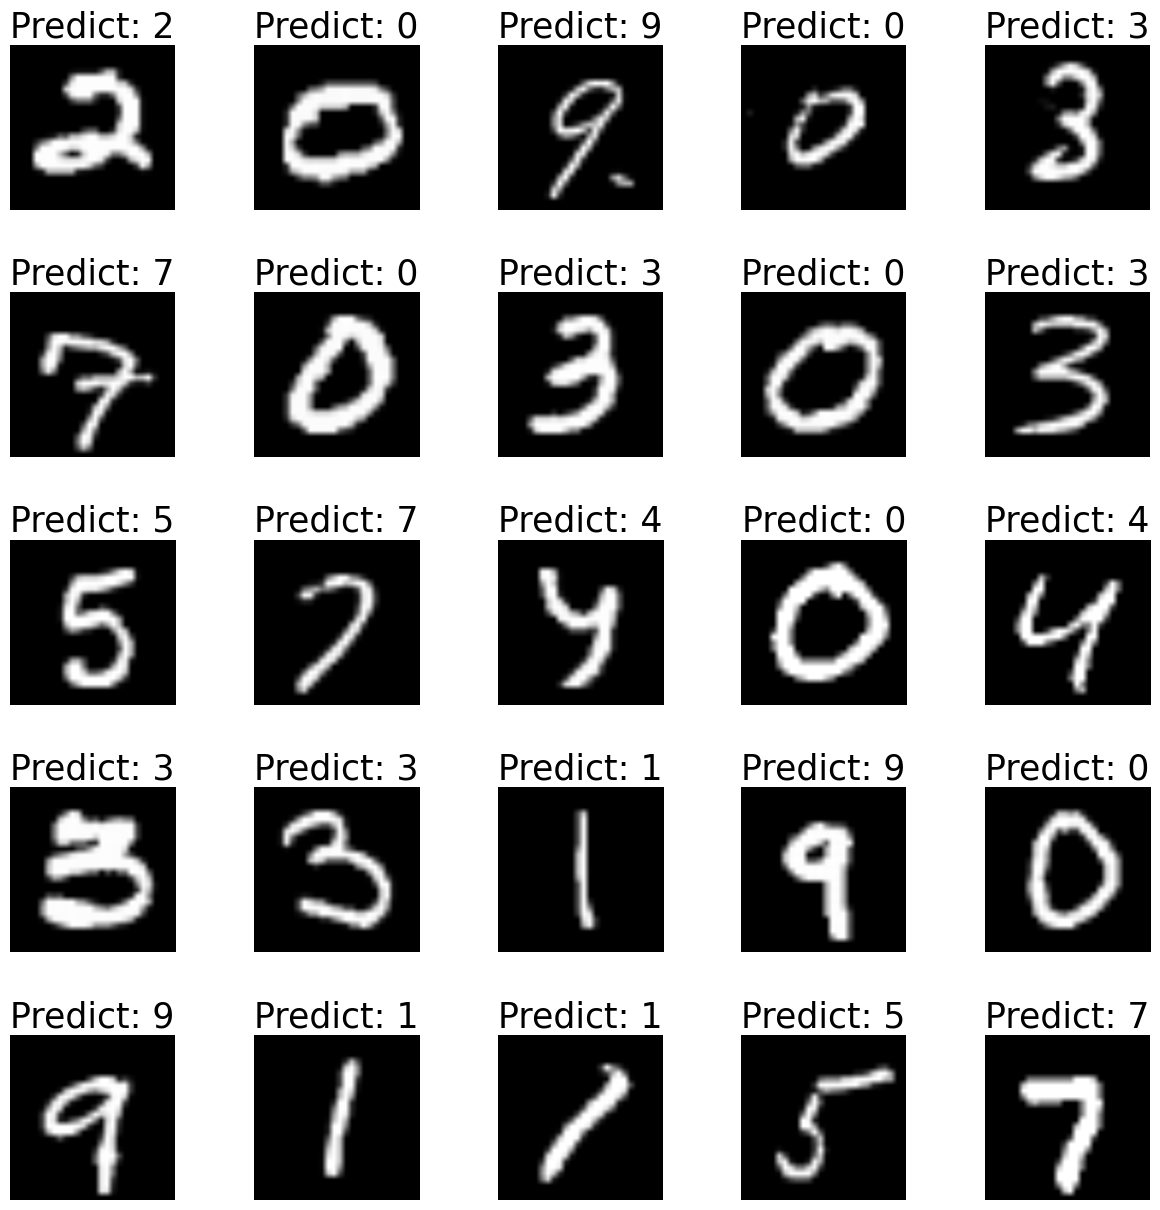

In [51]:
import matplotlib.pyplot as plt
import torch

# Function to make predictions
def test(img_tensorData, model):
    model.eval()
    with torch.no_grad():
        prediction = model(img_tensorData)
    return prediction.cpu().numpy()

# Plotting predictions
fig, axes = plt.subplots(5, 5, figsize=(15, 15))  # Adjust figsize to make plots larger
# fig.suptitle("Model Predictions", fontsize=80)  # Set an overall title for the figure
plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust the space between plots

for i, ax in enumerate(axes.flat):
    pic = torch.tensor(predict_array_list[i].reshape(1, 1, 224, 224)).float() / 255
    result = test(pic, model).argmax()

    ax.imshow(predict_array_list[i].reshape(224, 224), cmap='gray')
    ax.set_title(f"Predict: {result}", fontsize=25)
    ax.axis('off')  # Remove axis for cleaner look

plt.show()


